Esta primera celda carga todas las herramientas y librerías que necesitaremos para el proyecto. Esto incluye PyTorch (para la red neuronal), Torchvision (para las imágenes), NumPy (para cálculos), Matplotlib/Seaborn (para gráficos) y Scikit-learn (para las métricas de evaluación).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)
import os
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import datetime

Aquí definimos todas las constantes y variables clave.

In [2]:
CARPETA_DATOS_AGRUPADOS = './dataset_agrupad_o'
DIRECTORIO_DATOS = CARPETA_DATOS_AGRUPADOS
DIRECTORIO_KAGGLE = "/kaggle/input"

print(f"Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de {DIRECTORIO_KAGGLE}...")

DIRECTORIO_ENTRADA_BIOMAS = None
try:
    for ruta_actual, carpetas, archivos in os.walk(DIRECTORIO_KAGGLE, topdown=True):
        if os.path.basename(ruta_actual) == 'preprocessed_data':
            if any(carpeta.startswith('biome_') for carpeta in carpetas):
                DIRECTORIO_ENTRADA_BIOMAS = ruta_actual
                print(f"Directorio de biomas válido encontrado en: {DIRECTORIO_ENTRADA_BIOMAS}")
                print(f"Subdirectorios de biomas detectados (muestra): {carpetas[:5]}")
                break
    if DIRECTORIO_ENTRADA_BIOMAS is None:
        print("--- ERROR FATAL (DETECCIÓN) ---")
        print("No se pudo encontrar un directorio 'preprocessed_data' válido que contenga subcarpetas 'biome_X'.")
        DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"
except Exception as e:
    print(f"Error fatal al buscar directorios: {e}")
    DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"

#Aqui estan definidas estas constantes en funcion de como se presentan las imagenes del dataset 
ALTO_IMAGEN = 180
ANCHO_IMAGEN = 320
TAMANO_LOTE = 32
PROPORCION_VALIDACION = 1 / 3
SEMILLA_ALEATORIA = 123
UMBRAL_MINORIA = 1000

# Este es el mapa de las agrupaciones definidas en el anteproyecto
MAPA_AGRUPACION_BIOMAS = {
    "Taiga": ["biome_5", "biome_19", "biome_32", "biome_33", "biome_133"],
    "Taiga Nevada": ["biome_30", "biome_31", "biome_158"],
    "Savana": ["biome_35", "biome_36"],
    "Jungla": ["biome_21", "biome_22"],
    "Bosque de Roble Oscuro": ["biome_29", "biome_157"],
    "Desierto": ["biome_2", "biome_17", "biome_130"],
    "Badlands": ["biome_37", "biome_38", "biome_39"],
    "Bosque de Abeto": ["biome_27", "biome_28", "biome_156"],
    "Pantano": ["biome_6"],
    "Bosque de Roble": ["biome_4", "biome_132"],
    "Planicies": ["biome_1", "biome_129"],
    "Bosque Mixto": ["biome_18", "biome_34"],
    "Tundra Nevada": ["biome_12"],
    "Montañas": ["biome_3", "biome_131", "biome_162"],
    "Montaña Nevada": ["biome_13"],
    "Playa": ["biome_16", "biome_26"],
    "Ríos": ["biome_7", "biome_11"]
}

BIOMAS_IGNORADOS = ["biome_10", "biome_45"]

Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de /kaggle/input...
Directorio de biomas válido encontrado en: /kaggle/input/minecraft-biomes/preprocessed_data
Subdirectorios de biomas detectados (muestra): ['biome_7', 'biome_12', 'biome_37', 'biome_162', 'biome_158']


Esta celda define la función preparar_y_agrupar_biomas

In [3]:
def preparar_y_agrupar_biomas():
    print(f"Directorio base de entrada detectado: {DIRECTORIO_ENTRADA_BIOMAS}")
    if not DIRECTORIO_ENTRADA_BIOMAS or not os.path.exists(DIRECTORIO_ENTRADA_BIOMAS) or not os.listdir(DIRECTORIO_ENTRADA_BIOMAS):
        print(f"--- ERROR FATAL ---\nEl directorio '{DIRECTORIO_ENTRADA_BIOMAS}' no existe o está vacío.")
        return False

    os.makedirs(CARPETA_DATOS_AGRUPADOS, exist_ok=True)
    print(f"El dataset agrupado se guardará en: {CARPETA_DATOS_AGRUPADOS}")

    try:
        nombres_biomas_originales = next(os.walk(DIRECTORIO_ENTRADA_BIOMAS))[1]
    except (StopIteration, FileNotFoundError) as e:
        print(f"Error: No se encontró una estructura de directorios válida en {DIRECTORIO_ENTRADA_BIOMAS}. {e}")
        return False

    mapa_inverso_biomas = {}
    for nueva_categoria, lista_biomas_antiguos in MAPA_AGRUPACION_BIOMAS.items():
        for bioma_antiguo_id in lista_biomas_antiguos:
            mapa_inverso_biomas[bioma_antiguo_id] = nueva_categoria

    print("Creando directorios de salida para las categorías agrupadas...")
    todas_las_categorias = list(MAPA_AGRUPACION_BIOMAS.keys())
    for nueva_categoria in todas_las_categorias:
        os.makedirs(os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria), exist_ok=True)

    biomas_originales_mapeados = set()
    nombre_carpeta_raiz = os.path.basename(DIRECTORIO_ENTRADA_BIOMAS)

    print(f"Recorriendo {DIRECTORIO_ENTRADA_BIOMAS} en busca de imágenes...")
    for ruta_actual, _, archivos in tqdm(os.walk(DIRECTORIO_ENTRADA_BIOMAS), desc="Procesando biomas"):
        bioma_actual_id = os.path.basename(ruta_actual)

        if bioma_actual_id == nombre_carpeta_raiz or bioma_actual_id in BIOMAS_IGNORADOS:
            continue

        if bioma_actual_id in mapa_inverso_biomas:
            biomas_originales_mapeados.add(bioma_actual_id)
            nueva_categoria = mapa_inverso_biomas[bioma_actual_id]
            directorio_nueva_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria)

            for nombre_imagen in archivos:
                if not nombre_imagen.lower().endswith(('.jpg')):
                    continue

                ruta_origen = os.path.join(ruta_actual, nombre_imagen)
                nombre_destino = f"{bioma_actual_id}_{nombre_imagen}"
                ruta_destino = os.path.join(directorio_nueva_categoria, nombre_destino)

                if os.path.exists(ruta_destino):
                    continue

                try:
                    os.symlink(ruta_origen, ruta_destino)
                except (OSError, NotImplementedError, AttributeError):
                    import shutil
                    shutil.copy2(ruta_origen, ruta_destino)

    print("\n--- Proceso de agrupación completado ---")
    print("\n--- Verificación de Conteo (Desde carpetas de destino) ---")
    conteo_final_categorias = {}
    total_imagenes_agrupadas = 0

    for categoria in todas_las_categorias:
        ruta_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, categoria)
        try:
            archivos_en_categoria = os.listdir(ruta_categoria)
            conteo = len([f for f in archivos_en_categoria if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        except FileNotFoundError:
            conteo = 0
        conteo_final_categorias[categoria] = conteo
    
    total_imagenes_agrupadas = sum(conteo_final_categorias.values())
    print(f"Total de imágenes encontradas en las carpetas de destino: {total_imagenes_agrupadas}")

    if total_imagenes_agrupadas == 0:
        print("0 imagenes procesadas. ¡Algo salió mal!")
    else:
        print("\nCantidad total de imagenes encontradas:")
        for categoria, conteo in conteo_final_categorias.items():
            print(f"- {categoria}: {conteo} imágenes")

    todos_biomas_originales_en_mapa = biomas_originales_mapeados | set(BIOMAS_IGNORADOS)
    biomas_sin_mapa = [b for b in nombres_biomas_originales if b not in todos_biomas_originales_en_mapa]

    if biomas_sin_mapa:
        print(f"\n¡Atención! Los siguientes directorios no fueron mapeados ni excluidos:")
        for b in biomas_sin_mapa: print(f"  - {b}")
    else:
        print("\n¡Perfecto! Todos los directorios fueron trabajados correctamente.")
    
    return True

Esta celda define cargar_y_preparar_datos

In [4]:
def cargar_y_preparar_datos(directorio_datos):
    if not os.path.exists(directorio_datos) or not os.listdir(directorio_datos):
        print(f"Error: El directorio '{directorio_datos}' está vacío o no existe.")
        return None, None, None, None, 0

    transformaciones_entrenamiento = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomResizedCrop((ALTO_IMAGEN, ANCHO_IMAGEN), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformaciones_validacion = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("  -> Escaneando directorio de datos (ImageFolder)...")
    try:
        dataset_completo = datasets.ImageFolder(directorio_datos)
    except Exception as e:
        print(f"Error al cargar datos con ImageFolder desde '{directorio_datos}': {e}")
        return None, None, None, None, 0

    print(f"  -> Escaneo completo. {len(dataset_completo)} imágenes encontradas.")
    nombres_clases = dataset_completo.classes
    numero_de_clases = len(nombres_clases)
    print(f"Clases detectadas ({numero_de_clases}): {nombres_clases}")

    indices = list(range(len(dataset_completo)))
    corte = int(np.floor(PROPORCION_VALIDACION * len(dataset_completo)))

    np.random.seed(SEMILLA_ALEATORIA)
    np.random.shuffle(indices)

    indices_entrenamiento, indices_validacion = indices[corte:], indices[:corte]

    class DatasetPersonalizado(Dataset):
        def __init__(self, subset, transformacion):
            self.subset = subset
            self.transformacion = transformacion
        def __getitem__(self, index):
            imagen, etiqueta = self.subset[index]
            imagen = self.transformacion(imagen)
            return imagen, etiqueta
        def __len__(self):
            return len(self.subset)

    datos_entrenamiento = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_entrenamiento),
        transformacion=transformaciones_entrenamiento
    )
    datos_validacion = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_validacion),
        transformacion=transformaciones_validacion
    )

    print("  -> Calculando pesos para el muestreador (sampler)...")
    etiquetas_entrenamiento = []
    for i in tqdm(indices_entrenamiento, desc="   - Recopilando etiquetas (targets)"):
        etiquetas_entrenamiento.append(dataset_completo.targets[i])

    conteo_por_clase = np.bincount(etiquetas_entrenamiento, minlength=numero_de_clases)

    for i, nombre_clase in enumerate(nombres_clases):
        conteo = conteo_por_clase[i]
        if conteo < UMBRAL_MINORIA and conteo > 0:
            print(f"  -> (Sobremuestreo): {nombre_clase} (índice {i}) con {conteo} imágenes.")
        else:
            print(f"  -> (Normal): {nombre_clase} (índice {i}) con {conteo} imágenes.")

    conteo_por_clase[conteo_por_clase == 0] = 1
    pesos_por_clase = 1. / conteo_por_clase

    lista_pesos_muestras = []
    for t in tqdm(etiquetas_entrenamiento, desc="   - Calculando pesos (weights)"):
        lista_pesos_muestras.append(pesos_por_clase[t])
    pesos_muestras_tensor = torch.from_numpy(np.array(lista_pesos_muestras)).double()

    print("  -> Creando DataLoader de Validación...")
    cargador_validacion = DataLoader(datos_validacion,
                                   batch_size=TAMANO_LOTE,
                                   shuffle=False,
                                   num_workers=2,
                                   pin_memory=True)

    print(f"\nDatasets listos. Entreno: {len(datos_entrenamiento)}, Prueba: {len(datos_validacion)}")
    return datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases

Esta celda define la arquitectura de nuestra Red Neuronal Convolucional (CNN) usando una clase de PyTorch.

In [5]:
class ClasificadorBiomasCNN(nn.Module):
    def __init__(self, numero_de_clases, tipo_arquitectura="estandar"):
        super(ClasificadorBiomasCNN, self).__init__()
        self.tipo_arquitectura = tipo_arquitectura

        capas_convolucionales = []
        if tipo_arquitectura == "estandar":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(64, 128, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(128, 256, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 256 * 11 * 20

        elif tipo_arquitectura == "simple":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 64 * 45 * 80

        else:
            raise ValueError("Tipo de arquitectura no reconocido. Use 'estandar' o 'simple'.")

        self.extractor_caracteristicas = nn.Sequential(*capas_convolucionales)

        capas_clasificacion = []
        if tipo_arquitectura == "estandar":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 512))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(512, 256))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.3))
            capas_clasificacion.append(nn.Linear(256, numero_de_clases))

        elif tipo_arquitectura == "simple":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(128, numero_de_clases))
        self.clasificador_final = nn.Sequential(*capas_clasificacion)

    def forward(self, imagen):
        caracteristicas = self.extractor_caracteristicas(imagen)
        vector_plano = torch.flatten(caracteristicas, 1)
        puntuaciones = self.clasificador_final(vector_plano)
        return puntuaciones

Esta celda contiene las funciones que gestionan el ciclo de vida del modelo.

In [6]:
def entrenar_modelo(red_neuronal, cargador_entrenamiento, numero_epocas, tasa_aprendizaje, dispositivo):
    funcion_de_perdida = nn.CrossEntropyLoss()
    optimizador = optim.Adam(red_neuronal.parameters(), lr=tasa_aprendizaje)
    historial_perdida = []
    red_neuronal.to(dispositivo)

    for epoca in range(numero_epocas):
        perdida_acumulada = 0.0   
        red_neuronal.train()
        barra_progreso = tqdm(cargador_entrenamiento, desc=f"Época {epoca+1}/{numero_epocas}", unit="batch")

        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            optimizador.zero_grad()
            salidas = red_neuronal(imagenes)
            perdida = funcion_de_perdida(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            perdida_acumulada += perdida.item()
            barra_progreso.set_postfix(loss=perdida.item())
        perdida_promedio_epoca = perdida_acumulada / len(cargador_entrenamiento)
        historial_perdida.append(perdida_promedio_epoca)
        print(f"Época {epoca+1}/{numero_epocas} completada. Loss Promedio: {perdida_promedio_epoca:.4f}")
    print("Entrenamiento finalizado.")
    return historial_perdida

def graficar_historial_perdida(historial_perdida):
    plt.figure()
    plt.plot(historial_perdida, label='Pérdida (Loss) de Entrenamiento')
    plt.title("Historial de Pérdida (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluar_modelo(red_neuronal, cargador_pruebas, dispositivo, nombres_clases):
    red_neuronal.to(dispositivo)
    red_neuronal.eval()
    todas_predicciones = []
    todas_etiquetas_reales = []
    print("Evaluando modelo contra el conjunto de prueba...")
    barra_progreso = tqdm(cargador_pruebas, desc="Evaluando", unit="batch")
    with torch.no_grad():
        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = red_neuronal(imagenes)
            _, prediccion = torch.max(salidas.data, 1)         
            todas_predicciones.extend(prediccion.cpu().numpy())
            todas_etiquetas_reales.extend(etiquetas.cpu().numpy())
    accuracy = accuracy_score(todas_etiquetas_reales, todas_predicciones)
    precision = precision_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)
    recall = recall_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("          RESULTADOS DE LA EVALUACIÓN (BIOMAS)")
    print("="*60)
    print(f"Accuracy (Exactitud): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision (Precisión - Macro): {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall (Sensibilidad - Macro): {recall:.4f} ({recall*100:.2f}%)")
    print("="*60)
    print("\n--- Reporte de Clasificación (Precisión, Recall, F1) ---")
    print(classification_report(todas_etiquetas_reales, todas_predicciones, target_names=nombres_clases, zero_division=0))
    print("Generando Matriz de Confusión...")
    matriz_confusion = confusion_matrix(todas_etiquetas_reales, todas_predicciones)
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases, yticklabels=nombres_clases, annot_kws={"size": 10})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel("Bioma Predicho", fontsize=12)
    ax.set_ylabel("Bioma Real", fontsize=12)
    ax.set_title("Matriz de Confusión - Biomas", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()
    print("Gráfico de Matriz de Confusión generado.")

Esta celda define funciones de ayuda para gestionar el modelo y probarlo.

In [7]:
def guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo):
    estado_modelo = {
        'state_dict': red_neuronal.to('cpu').state_dict(),
        'arch_params': parametros_arquitectura
    }
    ruta_guardado = os.path.basename(nombre_archivo)
    if not ruta_guardado:
        ruta_guardado = "mi_modelo.pth"     
    torch.save(estado_modelo, ruta_guardado)
    print(f"Modelo guardado en {os.path.abspath(ruta_guardado)}")

def cargar_red_neuronal(nombre_archivo, dispositivo):
    if not os.path.exists(nombre_archivo):
        print(f"Error: El archivo '{nombre_archivo}' no existe.")
        return None, None       
    try:
        estado_cargado = torch.load(nombre_archivo, map_location=dispositivo)
    except Exception as e:
        print(f"Error al leer el archivo. ¿Es un archivo .pth válido? ({e})")
        return None, None
    if 'arch_params' not in estado_cargado or 'state_dict' not in estado_cargado:
        print("Error: El archivo .pth no contiene 'arch_params' o 'state_dict'.")
        return None, None
    parametros_arquitectura = estado_cargado['arch_params']
    if 'num_classes' not in parametros_arquitectura and 'numero_de_clases' in parametros_arquitectura:
        parametros_arquitectura['num_classes'] = parametros_arquitectura.pop('numero_de_clases')
    if 'architecture_type' not in parametros_arquitectura and 'tipo_arquitectura' in parametros_arquitectura:
        parametros_arquitectura['architecture_type'] = parametros_arquitectura.pop('tipo_arquitectura')
    params_creacion = {
        'numero_de_clases': parametros_arquitectura['num_classes'],
        'tipo_arquitectura': parametros_arquitectura.get('architecture_type', 'estandar') # default
    }
    red_neuronal = ClasificadorBiomasCNN(**params_creacion) 
    red_neuronal.load_state_dict(estado_cargado['state_dict'])
    red_neuronal.to(dispositivo)
    print(f"Modelo cargado desde {nombre_archivo} al dispositivo {dispositivo}")
    print("\n--- Configuración de la Red Cargada ---")
    print(f"Tipo: {params_creacion['tipo_arquitectura']}")
    print(f"Salida (Clases): {params_creacion['numero_de_clases']}")
    print(red_neuronal)
    print("--------------------------------------")
    return red_neuronal, parametros_arquitectura

def buscar_imagenes_para_predecir(directorio_busqueda, directorio_a_excluir):
    rutas_imagenes_encontradas = []
    print(f"Buscando imágenes de prueba en: {directorio_busqueda}")
    excluir_dataset_dir = ""
    if directorio_a_excluir and os.path.exists(directorio_a_excluir):
        excluir_dataset_dir = os.path.abspath(directorio_a_excluir)
        print(f"Excluyendo directorio de dataset: {excluir_dataset_dir}")      
    excluir_output_dir = os.path.abspath(CARPETA_DATOS_AGRUPADOS)
    print(f"Excluyendo directorio de salida: {excluir_output_dir}")
    for ruta_actual, _, archivos in os.walk(directorio_busqueda, topdown=True):
        ruta_absoluta = os.path.abspath(ruta_actual) 
        if excluir_dataset_dir and ruta_absoluta.startswith(excluir_dataset_dir):
            continue
        if ruta_absoluta.startswith(excluir_output_dir):
            continue
        for nombre_archivo in archivos:
            if nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                ruta_completa = os.path.join(ruta_actual, nombre_archivo)
                rutas_imagenes_encontradas.append(ruta_completa)
                
    return rutas_imagenes_encontradas

def predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo):
    print("\n--- Predecir Imagen Individual (Desde Lista) ---")
    imagenes_encontradas = buscar_imagenes_para_predecir(DIRECTORIO_KAGGLE, DIRECTORIO_ENTRADA_BIOMAS)
    
    if not imagenes_encontradas:
        print(f"No se encontraron imágenes de prueba (jpg, png) en '{DIRECTORIO_KAGGLE}'")
        print(f"(Asegúrese de que NO estén dentro de '{DIRECTORIO_ENTRADA_BIOMAS}')")
        print("Por favor, añada un dataset que contenga imágenes de prueba (ej. 'test-images').")
        return

    print("Imágenes de prueba encontradas:")
    for i, ruta_img in enumerate(imagenes_encontradas):
        ruta_mostrada = ruta_img.replace(DIRECTORIO_KAGGLE, '.../input')
        print(f"  {i + 1}: {ruta_mostrada}")

    ruta_elegida = None
    while ruta_elegida is None:
        try:
            opcion_str = input(f"Seleccione el número de la imagen (1-{len(imagenes_encontradas)}): ")
            opcion_int = int(opcion_str) - 1
            if 0 <= opcion_int < len(imagenes_encontradas):
                ruta_elegida = imagenes_encontradas[opcion_int]
            else:
                print("Número fuera de rango. Intente de nuevo.")
        except ValueError:
            print("Entrada no válida. Por favor, ingrese un número.")

    print(f"Cargando imagen seleccionada: {ruta_elegida}")
    try:
        transformaciones_prediccion = transforms.Compose([
            transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        imagen = Image.open(ruta_elegida).convert("RGB")
        imagen_tensor = transformaciones_prediccion(imagen)
        imagen_lote = imagen_tensor.unsqueeze(0)
        red_neuronal.to(dispositivo)
        red_neuronal.eval()

        with torch.no_grad():
            salidas = red_neuronal(imagen_lote.to(dispositivo))
            probabilidades = torch.nn.functional.softmax(salidas, dim=1)
            puntuaciones = probabilidades[0]
            confianza, indice_predicho = torch.max(puntuaciones, 0)

        clase_predicha = nombres_clases[indice_predicho.item()]

        print("\n--- Resultado ---")
        print(f"Archivo: {os.path.basename(ruta_elegida)}")
        print(f"La red cree que es: {clase_predicha}")
        print(f"Confianza: {confianza.item() * 100:.2f}%")

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")

Esta celda define la interfaz de usuario que nos permite interactuar con el modelo cuando corre en draft

In [8]:
def menu_interactivo_modelo(red_neuronal, parametros_arquitectura, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo):
    historial_perdida = []
    
    while True:
        print("\n--- Menú de Red - Clasificador de Biomas ---")
        print(f"Modelo en memoria: {parametros_arquitectura.get('architecture_type', 'N/A')}")
        print("1. Entrenar la red")
        print("2. Probar (Evaluar) la red")
        print("3. Predecir imagen individual")
        print("4. Guardar la red")
        print("5. Volver al menú principal")
        opcion = input("Seleccione una opción: ")

        if opcion == '1':
            try:
                epocas = int(input("Ingrese el número de épocas (ej. 10): ") or 10)
                lr = float(input("Ingrese la tasa de aprendizaje (ej. 0.001): ") or 0.001)
                porcentaje_str = input("Porcentaje del dataset de entrenamiento a usar (1-100) [Default: 100]: ") or "100"
                porcentaje = float(porcentaje_str) / 100.0
                
                if not (0.01 <= porcentaje <= 1.0):
                    print("Porcentaje inválido. Usando 100%.")
                    porcentaje = 1.0
                    
                total_muestras_entrenamiento = len(pesos_muestras_tensor)
                
                if porcentaje < 1.0:
                    muestras_a_usar = int(total_muestras_entrenamiento * porcentaje)
                    print(f"Usando {porcentaje*100:.0f}% del dataset. {muestras_a_usar} muestras por época.")
                else:
                    muestras_a_usar = total_muestras_entrenamiento
                    print(f"Usando 100% del dataset. {muestras_a_usar} muestras por época.")

                muestreador_entrenamiento = torch.utils.data.WeightedRandomSampler(
                    weights=pesos_muestras_tensor,
                    num_samples=muestras_a_usar,
                    replacement=True
                )
                
                cargador_entrenamiento_actual = DataLoader(datos_entrenamiento,
                                                          batch_size=TAMANO_LOTE,
                                                          sampler=muestreador_entrenamiento,
                                                          num_workers=2,
                                                          pin_memory=True)

                print(f"Entrenando por {epocas} épocas con LR={lr} en {dispositivo}...")
                nueva_perdida = entrenar_modelo(red_neuronal, cargador_entrenamiento_actual, epocas, lr, dispositivo)
                historial_perdida.extend(nueva_perdida)
                graficar_historial_perdida(historial_perdida)

            except ValueError:
                print("Error: Entrada no válida.")
        
        elif opcion == '2':
            print(f"Probando modelo contra el conjunto de prueba en {dispositivo}...")
            evaluar_modelo(red_neuronal, cargador_validacion, dispositivo, nombres_clases)
        
        elif opcion == '3':
            predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo)
        
        elif opcion == '4':
            nombre_archivo = input("Ingrese el nombre para guardar el modelo (ej: mi_modelo.pth): ")
            if not nombre_archivo.endswith(".pth"):
                nombre_archivo += ".pth"
            if nombre_archivo:
                guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo)
            else:
                print("Guardado cancelado (nombre vacío).")
        
        elif opcion == '5':
            print("Volviendo al menú principal...")
            break
        
        else:
            print("Opción no válida. Intente de nuevo.")

def menu_principal():
    red_neuronal_activa = None
    params_arquitectura_activos = None
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while True:
        print("\n" + "="*50)
        print("  Panel de Control - Clasificador de Biomas (PyTorch)")
        print(f" (Usando dispositivo: {dispositivo})")
        print("="*50)
        print("1. Preparar datos y Crear nueva red (CNN)")
        print("2. Cargar una red desde archivo (.pth)")
        print("3. Salir")
        opcion_principal = input("Seleccione una opción: ")

        if opcion_principal == '1':
            try:
                print("\n--- FASE 1: Agrupando y verificando el dataset ---")
                if not preparar_y_agrupar_biomas():
                    print("Error crítico en la agrupación del dataset. Abortando.")
                    continue

                print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
                
                if datos_entrenamiento is None:
                    print("No se pudieron cargar los datos. Volviendo al menú.")
                    continue
                print("\n--- FASE 3: Creación de Modelo (CNN) ---")
                opcion_arquitectura = input("¿Qué arquitectura desea? (1: Estándar, 2: Simple) [Default: 1]: ") or "1"
                tipo_arquitectura = "simple" if opcion_arquitectura == "2" else "estandar"
                params_arquitectura_activos = {
                    'num_classes': numero_de_clases,
                    'architecture_type': tipo_arquitectura
                }
                
                params_creacion_modelo = {
                    'numero_de_clases': params_arquitectura_activos['num_classes'],
                    'tipo_arquitectura': params_arquitectura_activos['architecture_type']
                }

                red_neuronal_activa = ClasificadorBiomasCNN(**params_creacion_modelo).to(dispositivo)
                print("\n--- Nueva Red CNN Creada ---")
                print(red_neuronal_activa)
                print("------------------------------")  
                menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except ValueError:
                print("Error: Entrada numérica no válida.")
            except Exception as e:
                print(f"Ocurrió un error creando la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '2':
            print("\n--- Cargar Modelo ---")
            print("Buscando archivos .pth en el directorio actual y subdirectorios...")
            archivos_pth_encontrados = []
            for ruta_actual, _, archivos in os.walk('.'):
                for f in archivos:
                    if f.endswith(".pth"):
                        archivos_pth_encontrados.append(os.path.join(ruta_actual, f))
            
            if not archivos_pth_encontrados:
                print("No se encontraron archivos .pth.")
                print("Asegúrate de haber guardado un modelo previamente.")
                continue

            print("Archivos .pth encontrados:")
            for i, ruta_archivo in enumerate(archivos_pth_encontrados):
                print(f"  {i + 1}: {ruta_archivo}")
            nombre_archivo_cargado = None
            while nombre_archivo_cargado is None:
                try:
                    opcion_str = input(f"Seleccione el número del modelo a cargar (1-{len(archivos_pth_encontrados)}): ")
                    opcion_int = int(opcion_str) - 1
                    if 0 <= opcion_int < len(archivos_pth_encontrados):
                        nombre_archivo_cargado = archivos_pth_encontrados[opcion_int]
                    else:
                        print("Número fuera de rango.")
                except ValueError:
                    print("Entrada no válida.")
            
            print(f"Cargando modelo: {nombre_archivo_cargado}")
            try:
                red_neuronal_activa, params_arquitectura_activos = cargar_red_neuronal(nombre_archivo_cargado, dispositivo)
                
                if red_neuronal_activa and params_arquitectura_activos:
                    print("\n--- FASE 1: Verificando datos (necesarios para la red cargada) ---")
                    if not os.path.exists(DIRECTORIO_DATOS) or not os.listdir(DIRECTORIO_DATOS):
                        print("El directorio de datos agrupados no existe. Ejecutando agrupación...")
                        if not preparar_y_agrupar_biomas():
                            print("Error crítico en la agrupación del dataset. Abortando.")
                            continue
                    else:
                        print("Directorio de datos agrupados encontrado.")
                    print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                    datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)           
                    if datos_entrenamiento is None:
                        print("No se pudieron cargar los datos para la red. Volviendo al menú.")
                        continue        
                    if numero_de_clases != params_arquitectura_activos['num_classes']:
                        print(f"¡ADVERTENCIA! El modelo fue entrenado con {params_arquitectura_activos['num_classes']} clases,")
                        print(f"pero los datos en '{DIRECTORIO_DATOS}' tienen {numero_de_clases} clases.")
                        print("Esto causará un error. Asegúrate de que los datos agrupados coincidan con el modelo.")
                        continue
                        
                    menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except FileNotFoundError:
                print(f"Error: El archivo '{nombre_archivo_cargado}' no fue encontrado.")
            except Exception as e:
                print(f"Ocurrió un error al cargar o probar la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '3':
            print("Saliendo del programa.")
            break
        
        else:
            print("Opción no válida. Por favor, intente de nuevo.")

Punto de ejecucion del codigo donde se termina de definir

--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---
Iniciando flujo automático (sin inputs).

 (Usando dispositivo: cuda)

--- FASE 1: Agrupando y verificando el dataset ---
Directorio base de entrada detectado: /kaggle/input/minecraft-biomes/preprocessed_data
El dataset agrupado se guardará en: ./dataset_agrupad_o
Creando directorios de salida para las categorías agrupadas...
Recorriendo /kaggle/input/minecraft-biomes/preprocessed_data en busca de imágenes...


Procesando biomas: 42it [00:16,  2.54it/s]



--- Proceso de agrupación completado ---

--- Verificación de Conteo (Desde carpetas de destino) ---
Total de imágenes encontradas en las carpetas de destino: 22049

Cantidad total de imagenes encontradas:
- Taiga: 2346 imágenes
- Taiga Nevada: 420 imágenes
- Savana: 1164 imágenes
- Jungla: 444 imágenes
- Bosque de Roble Oscuro: 870 imágenes
- Desierto: 2088 imágenes
- Badlands: 210 imágenes
- Bosque de Abeto: 1122 imágenes
- Pantano: 665 imágenes
- Bosque de Roble: 2850 imágenes
- Planicies: 3186 imágenes
- Bosque Mixto: 1320 imágenes
- Tundra Nevada: 1254 imágenes
- Montañas: 2652 imágenes
- Montaña Nevada: 474 imágenes
- Playa: 540 imágenes
- Ríos: 444 imágenes

¡Perfecto! Todos los directorios fueron trabajados correctamente.

--- FASE 2: Cargando y preparando datasets (PyTorch) ---
  -> Escaneando directorio de datos (ImageFolder)...
  -> Escaneo completo. 22049 imágenes encontradas.
Clases detectadas (17): ['Badlands', 'Bosque Mixto', 'Bosque de Abeto', 'Bosque de Roble', 'Bosqu

   - Recopilando etiquetas (targets): 100%|██████████| 14700/14700 [00:00<00:00, 3610908.86it/s]


  -> (Sobremuestreo): Badlands (índice 0) con 146 imágenes.
  -> (Sobremuestreo): Bosque Mixto (índice 1) con 861 imágenes.
  -> (Sobremuestreo): Bosque de Abeto (índice 2) con 767 imágenes.
  -> (Normal): Bosque de Roble (índice 3) con 1920 imágenes.
  -> (Sobremuestreo): Bosque de Roble Oscuro (índice 4) con 568 imágenes.
  -> (Normal): Desierto (índice 5) con 1406 imágenes.
  -> (Sobremuestreo): Jungla (índice 6) con 305 imágenes.
  -> (Sobremuestreo): Montaña Nevada (índice 7) con 301 imágenes.
  -> (Normal): Montañas (índice 8) con 1783 imágenes.
  -> (Sobremuestreo): Pantano (índice 9) con 450 imágenes.
  -> (Normal): Planicies (índice 10) con 2122 imágenes.
  -> (Sobremuestreo): Playa (índice 11) con 356 imágenes.
  -> (Sobremuestreo): Ríos (índice 12) con 306 imágenes.
  -> (Sobremuestreo): Savana (índice 13) con 774 imágenes.
  -> (Normal): Taiga (índice 14) con 1534 imágenes.
  -> (Sobremuestreo): Taiga Nevada (índice 15) con 273 imágenes.
  -> (Sobremuestreo): Tundra Nevada 

   - Calculando pesos (weights): 100%|██████████| 14700/14700 [00:00<00:00, 2863471.52it/s]

  -> Creando DataLoader de Validación...

Datasets listos. Entreno: 14700, Prueba: 7349

--- FASE 3: Creación de Modelo (CNN) ---
Arquitectura seleccionada: estandar



--- Nueva Red CNN Creada ---

--- FASE 4: Iniciando Entrenamiento ---
Épocas: 200, LR: 0.002, Dataset: 100%


Época 1/200: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=1.32]


Época 1/200 completada. Loss Promedio: 1.7480


Época 2/200: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=1.09]


Época 2/200 completada. Loss Promedio: 1.2037


Época 3/200: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.532]


Época 3/200 completada. Loss Promedio: 1.0403


Época 4/200: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=1.74]


Época 4/200 completada. Loss Promedio: 0.9388


Época 5/200: 100%|██████████| 460/460 [00:57<00:00,  7.95batch/s, loss=0.449]


Época 5/200 completada. Loss Promedio: 0.8973


Época 6/200: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.349]


Época 6/200 completada. Loss Promedio: 0.9054


Época 7/200: 100%|██████████| 460/460 [00:50<00:00,  9.08batch/s, loss=1.63]


Época 7/200 completada. Loss Promedio: 0.8113


Época 8/200: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.768]


Época 8/200 completada. Loss Promedio: 0.7255


Época 9/200: 100%|██████████| 460/460 [00:50<00:00,  9.17batch/s, loss=0.315]


Época 9/200 completada. Loss Promedio: 0.7197


Época 10/200: 100%|██████████| 460/460 [00:50<00:00,  9.10batch/s, loss=0.41]


Época 10/200 completada. Loss Promedio: 0.7191


Época 11/200: 100%|██████████| 460/460 [00:55<00:00,  8.32batch/s, loss=0.458]


Época 11/200 completada. Loss Promedio: 0.7048


Época 12/200: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.702]


Época 12/200 completada. Loss Promedio: 0.6606


Época 13/200: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.19]


Época 13/200 completada. Loss Promedio: 0.6585


Época 14/200: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=1.09]


Época 14/200 completada. Loss Promedio: 0.6616


Época 15/200: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.598]


Época 15/200 completada. Loss Promedio: 0.6391


Época 16/200: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.219]


Época 16/200 completada. Loss Promedio: 0.6083


Época 17/200: 100%|██████████| 460/460 [00:51<00:00,  8.98batch/s, loss=0.592]


Época 17/200 completada. Loss Promedio: 0.6350


Época 18/200: 100%|██████████| 460/460 [00:54<00:00,  8.48batch/s, loss=1.72]


Época 18/200 completada. Loss Promedio: 0.6307


Época 19/200: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.996]


Época 19/200 completada. Loss Promedio: 0.6110


Época 20/200: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=1.08]


Época 20/200 completada. Loss Promedio: 0.5757


Época 21/200: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.208]


Época 21/200 completada. Loss Promedio: 0.5792


Época 22/200: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.398]


Época 22/200 completada. Loss Promedio: 0.5293


Época 23/200: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.581]


Época 23/200 completada. Loss Promedio: 0.6216


Época 24/200: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.43]


Época 24/200 completada. Loss Promedio: 0.5466


Época 25/200: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.791]


Época 25/200 completada. Loss Promedio: 0.5567


Época 26/200: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=0.793]


Época 26/200 completada. Loss Promedio: 0.6164


Época 27/200: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.845]


Época 27/200 completada. Loss Promedio: 0.5796


Época 28/200: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.672]


Época 28/200 completada. Loss Promedio: 0.5482


Época 29/200: 100%|██████████| 460/460 [00:52<00:00,  8.70batch/s, loss=0.214]


Época 29/200 completada. Loss Promedio: 0.5361


Época 30/200: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.831]


Época 30/200 completada. Loss Promedio: 0.5416


Época 31/200: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.359]


Época 31/200 completada. Loss Promedio: 0.4908


Época 32/200: 100%|██████████| 460/460 [00:55<00:00,  8.22batch/s, loss=0.394]


Época 32/200 completada. Loss Promedio: 0.5303


Época 33/200: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=0.812]


Época 33/200 completada. Loss Promedio: 0.5183


Época 34/200: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.509]


Época 34/200 completada. Loss Promedio: 0.4901


Época 35/200: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=1]


Época 35/200 completada. Loss Promedio: 0.5251


Época 36/200: 100%|██████████| 460/460 [00:52<00:00,  8.84batch/s, loss=0.305]


Época 36/200 completada. Loss Promedio: 0.5205


Época 37/200: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.177]


Época 37/200 completada. Loss Promedio: 0.5214


Época 38/200: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.739]


Época 38/200 completada. Loss Promedio: 0.4953


Época 39/200: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.441]


Época 39/200 completada. Loss Promedio: 0.5689


Época 40/200: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.21]


Época 40/200 completada. Loss Promedio: 0.4964


Época 41/200: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.0806]


Época 41/200 completada. Loss Promedio: 0.4733


Época 42/200: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.487]


Época 42/200 completada. Loss Promedio: 0.4922


Época 43/200: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.329]


Época 43/200 completada. Loss Promedio: 0.4717


Época 44/200: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=1.12]


Época 44/200 completada. Loss Promedio: 0.5015


Época 45/200: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.754]


Época 45/200 completada. Loss Promedio: 0.4595


Época 46/200: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.238]


Época 46/200 completada. Loss Promedio: 0.5015


Época 47/200: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.52]


Época 47/200 completada. Loss Promedio: 0.4622


Época 48/200: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.424]


Época 48/200 completada. Loss Promedio: 0.4488


Época 49/200: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.228]


Época 49/200 completada. Loss Promedio: 0.5920


Época 50/200: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.258]


Época 50/200 completada. Loss Promedio: 0.5077


Época 51/200: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.0697]


Época 51/200 completada. Loss Promedio: 0.4836


Época 52/200: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.799]


Época 52/200 completada. Loss Promedio: 0.4407


Época 53/200: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.26]


Época 53/200 completada. Loss Promedio: 0.4473


Época 54/200: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.463]


Época 54/200 completada. Loss Promedio: 0.4638


Época 55/200: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.087]


Época 55/200 completada. Loss Promedio: 0.4809


Época 56/200: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=2.57]


Época 56/200 completada. Loss Promedio: 0.4466


Época 57/200: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.309]


Época 57/200 completada. Loss Promedio: 0.4966


Época 58/200: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.362]


Época 58/200 completada. Loss Promedio: 0.4482


Época 59/200: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.319]


Época 59/200 completada. Loss Promedio: 0.4576


Época 60/200: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.21]


Época 60/200 completada. Loss Promedio: 0.4457


Época 61/200: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.424]


Época 61/200 completada. Loss Promedio: 0.4543


Época 62/200: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.249]


Época 62/200 completada. Loss Promedio: 0.4841


Época 63/200: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.255]


Época 63/200 completada. Loss Promedio: 0.4562


Época 64/200: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.414]


Época 64/200 completada. Loss Promedio: 0.4536


Época 65/200: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=0.267]


Época 65/200 completada. Loss Promedio: 0.4374


Época 66/200: 100%|██████████| 460/460 [00:55<00:00,  8.22batch/s, loss=0.629]


Época 66/200 completada. Loss Promedio: 0.4517


Época 67/200: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.405]


Época 67/200 completada. Loss Promedio: 0.4235


Época 68/200: 100%|██████████| 460/460 [00:57<00:00,  7.99batch/s, loss=0.675]


Época 68/200 completada. Loss Promedio: 0.4227


Época 69/200: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.17]


Época 69/200 completada. Loss Promedio: 0.4349


Época 70/200: 100%|██████████| 460/460 [00:59<00:00,  7.78batch/s, loss=0.293]


Época 70/200 completada. Loss Promedio: 0.4503


Época 71/200: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.213]


Época 71/200 completada. Loss Promedio: 0.4192


Época 72/200: 100%|██████████| 460/460 [00:57<00:00,  7.99batch/s, loss=0.82]


Época 72/200 completada. Loss Promedio: 0.4479


Época 73/200: 100%|██████████| 460/460 [00:57<00:00,  7.95batch/s, loss=0.37]


Época 73/200 completada. Loss Promedio: 0.4475


Época 74/200: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=0.385]


Época 74/200 completada. Loss Promedio: 0.4427


Época 75/200: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.326]


Época 75/200 completada. Loss Promedio: 0.4217


Época 76/200: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.25]


Época 76/200 completada. Loss Promedio: 0.4357


Época 77/200: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.136]


Época 77/200 completada. Loss Promedio: 0.3968


Época 78/200: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.962]


Época 78/200 completada. Loss Promedio: 0.4257


Época 79/200: 100%|██████████| 460/460 [00:58<00:00,  7.91batch/s, loss=0.399]


Época 79/200 completada. Loss Promedio: 0.4232


Época 80/200: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.26]


Época 80/200 completada. Loss Promedio: 0.4223


Época 81/200: 100%|██████████| 460/460 [01:02<00:00,  7.41batch/s, loss=0.536]


Época 81/200 completada. Loss Promedio: 0.4122


Época 82/200: 100%|██████████| 460/460 [01:08<00:00,  6.75batch/s, loss=0.281]


Época 82/200 completada. Loss Promedio: 0.4051


Época 83/200: 100%|██████████| 460/460 [01:10<00:00,  6.57batch/s, loss=0.123]


Época 83/200 completada. Loss Promedio: 0.3988


Época 84/200: 100%|██████████| 460/460 [01:04<00:00,  7.12batch/s, loss=0.939]


Época 84/200 completada. Loss Promedio: 0.4147


Época 85/200: 100%|██████████| 460/460 [01:05<00:00,  7.04batch/s, loss=1.72]


Época 85/200 completada. Loss Promedio: 0.4762


Época 86/200: 100%|██████████| 460/460 [01:02<00:00,  7.36batch/s, loss=0.616]


Época 86/200 completada. Loss Promedio: 0.4637


Época 87/200: 100%|██████████| 460/460 [00:59<00:00,  7.73batch/s, loss=0.267]


Época 87/200 completada. Loss Promedio: 0.4088


Época 88/200: 100%|██████████| 460/460 [00:58<00:00,  7.82batch/s, loss=0.481]


Época 88/200 completada. Loss Promedio: 0.4010


Época 89/200: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.28]


Época 89/200 completada. Loss Promedio: 0.4101


Época 90/200: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.213]


Época 90/200 completada. Loss Promedio: 0.4429


Época 91/200: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.219]


Época 91/200 completada. Loss Promedio: 0.4375


Época 92/200: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.461]


Época 92/200 completada. Loss Promedio: 0.4120


Época 93/200: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.0488]


Época 93/200 completada. Loss Promedio: 0.4138


Época 94/200: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.139]


Época 94/200 completada. Loss Promedio: 0.3990


Época 95/200: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.402]


Época 95/200 completada. Loss Promedio: 0.4112


Época 96/200: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.189]


Época 96/200 completada. Loss Promedio: 0.4274


Época 97/200: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.251]


Época 97/200 completada. Loss Promedio: 0.3848


Época 98/200: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.849]


Época 98/200 completada. Loss Promedio: 0.4709


Época 99/200: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.473]


Época 99/200 completada. Loss Promedio: 0.3882


Época 100/200: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.253]


Época 100/200 completada. Loss Promedio: 0.4102


Época 101/200: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.131]


Época 101/200 completada. Loss Promedio: 0.4254


Época 102/200: 100%|██████████| 460/460 [00:55<00:00,  8.22batch/s, loss=0.799]


Época 102/200 completada. Loss Promedio: 0.4013


Época 103/200: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.0579]


Época 103/200 completada. Loss Promedio: 0.4180


Época 104/200: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.184]


Época 104/200 completada. Loss Promedio: 0.4165


Época 105/200: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.632]


Época 105/200 completada. Loss Promedio: 0.4706


Época 106/200: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.349]


Época 106/200 completada. Loss Promedio: 0.3913


Época 107/200: 100%|██████████| 460/460 [00:51<00:00,  8.87batch/s, loss=0.257]


Época 107/200 completada. Loss Promedio: 0.4327


Época 108/200: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.411]


Época 108/200 completada. Loss Promedio: 0.3803


Época 109/200: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.187]


Época 109/200 completada. Loss Promedio: 0.3817


Época 110/200: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.397]


Época 110/200 completada. Loss Promedio: 0.3928


Época 111/200: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.228]


Época 111/200 completada. Loss Promedio: 0.4792


Época 112/200: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=0.334]


Época 112/200 completada. Loss Promedio: 0.4210


Época 113/200: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.679]


Época 113/200 completada. Loss Promedio: 0.4074


Época 114/200: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.382]


Época 114/200 completada. Loss Promedio: 0.4396


Época 115/200: 100%|██████████| 460/460 [00:58<00:00,  7.82batch/s, loss=0.011]


Época 115/200 completada. Loss Promedio: 0.3554


Época 116/200: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.0103]


Época 116/200 completada. Loss Promedio: 0.3809


Época 117/200: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.117]


Época 117/200 completada. Loss Promedio: 0.4003


Época 118/200: 100%|██████████| 460/460 [00:59<00:00,  7.72batch/s, loss=1.44]


Época 118/200 completada. Loss Promedio: 0.4653


Época 119/200: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=0.247]


Época 119/200 completada. Loss Promedio: 0.5438


Época 120/200: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.19]


Época 120/200 completada. Loss Promedio: 0.3806


Época 121/200: 100%|██████████| 460/460 [00:57<00:00,  7.96batch/s, loss=0.351]


Época 121/200 completada. Loss Promedio: 0.3739


Época 122/200: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.274]


Época 122/200 completada. Loss Promedio: 0.3633


Época 123/200: 100%|██████████| 460/460 [00:58<00:00,  7.88batch/s, loss=0.124]


Época 123/200 completada. Loss Promedio: 0.3652


Época 124/200: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.296]


Época 124/200 completada. Loss Promedio: 0.4056


Época 125/200: 100%|██████████| 460/460 [00:57<00:00,  7.96batch/s, loss=0.334]


Época 125/200 completada. Loss Promedio: 0.4269


Época 126/200: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.532]


Época 126/200 completada. Loss Promedio: 0.4087


Época 127/200: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.874]


Época 127/200 completada. Loss Promedio: 0.3827


Época 128/200: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=1.54]


Época 128/200 completada. Loss Promedio: 0.3893


Época 129/200: 100%|██████████| 460/460 [00:57<00:00,  7.99batch/s, loss=0.11]


Época 129/200 completada. Loss Promedio: 0.4268


Época 130/200: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.187]


Época 130/200 completada. Loss Promedio: 0.3626


Época 131/200: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.374]


Época 131/200 completada. Loss Promedio: 0.3983


Época 132/200: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.591]


Época 132/200 completada. Loss Promedio: 0.3787


Época 133/200: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.513]


Época 133/200 completada. Loss Promedio: 0.3620


Época 134/200: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.41]


Época 134/200 completada. Loss Promedio: 0.3648


Época 135/200: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.373]


Época 135/200 completada. Loss Promedio: 0.4161


Época 136/200: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.316]


Época 136/200 completada. Loss Promedio: 0.4047


Época 137/200: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.213]


Época 137/200 completada. Loss Promedio: 0.3873


Época 138/200: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.653]


Época 138/200 completada. Loss Promedio: 0.4003


Época 139/200: 100%|██████████| 460/460 [00:58<00:00,  7.91batch/s, loss=0.312]


Época 139/200 completada. Loss Promedio: 0.3855


Época 140/200: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=0.301]


Época 140/200 completada. Loss Promedio: 0.3824


Época 141/200: 100%|██████████| 460/460 [00:59<00:00,  7.80batch/s, loss=0.305]


Época 141/200 completada. Loss Promedio: 0.4534


Época 142/200: 100%|██████████| 460/460 [00:58<00:00,  7.83batch/s, loss=0.0376]


Época 142/200 completada. Loss Promedio: 0.3635


Época 143/200: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.16]


Época 143/200 completada. Loss Promedio: 0.4020


Época 144/200: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.207]


Época 144/200 completada. Loss Promedio: 0.4006


Época 145/200: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.0501]


Época 145/200 completada. Loss Promedio: 0.3869


Época 146/200: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.281]


Época 146/200 completada. Loss Promedio: 0.4097


Época 147/200: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.189]


Época 147/200 completada. Loss Promedio: 0.3955


Época 148/200: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.476]


Época 148/200 completada. Loss Promedio: 0.3584


Época 149/200: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.03]


Época 149/200 completada. Loss Promedio: 0.4345


Época 150/200: 100%|██████████| 460/460 [00:58<00:00,  7.91batch/s, loss=0.232]


Época 150/200 completada. Loss Promedio: 0.4125


Época 151/200: 100%|██████████| 460/460 [00:51<00:00,  8.93batch/s, loss=0.0245]


Época 151/200 completada. Loss Promedio: 0.4126


Época 152/200: 100%|██████████| 460/460 [00:55<00:00,  8.33batch/s, loss=0.274]


Época 152/200 completada. Loss Promedio: 0.3864


Época 153/200: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.395]


Época 153/200 completada. Loss Promedio: 0.3709


Época 154/200: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.0469]


Época 154/200 completada. Loss Promedio: 0.3511


Época 155/200: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.172]


Época 155/200 completada. Loss Promedio: 0.3629


Época 156/200: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.0308]


Época 156/200 completada. Loss Promedio: 0.3572


Época 157/200: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.187]


Época 157/200 completada. Loss Promedio: 0.3815


Época 158/200: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.415]


Época 158/200 completada. Loss Promedio: 0.4333


Época 159/200: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.577]


Época 159/200 completada. Loss Promedio: 0.3624


Época 160/200: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.249]


Época 160/200 completada. Loss Promedio: 0.4299


Época 161/200: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.0788]


Época 161/200 completada. Loss Promedio: 0.3803


Época 162/200: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.412]


Época 162/200 completada. Loss Promedio: 0.3513


Época 163/200: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.726]


Época 163/200 completada. Loss Promedio: 0.4665


Época 164/200: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.152]


Época 164/200 completada. Loss Promedio: 0.3689


Época 165/200: 100%|██████████| 460/460 [00:57<00:00,  7.95batch/s, loss=0.14]


Época 165/200 completada. Loss Promedio: 0.3759


Época 166/200: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.0205]


Época 166/200 completada. Loss Promedio: 0.3502


Época 167/200: 100%|██████████| 460/460 [00:59<00:00,  7.79batch/s, loss=1.17]


Época 167/200 completada. Loss Promedio: 0.3567


Época 168/200: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.226]


Época 168/200 completada. Loss Promedio: 0.3825


Época 169/200: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.149]


Época 169/200 completada. Loss Promedio: 0.3795


Época 170/200: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.405]


Época 170/200 completada. Loss Promedio: 0.3883


Época 171/200: 100%|██████████| 460/460 [00:58<00:00,  7.89batch/s, loss=0.379]


Época 171/200 completada. Loss Promedio: 0.3693


Época 172/200: 100%|██████████| 460/460 [00:57<00:00,  7.96batch/s, loss=0.0115]


Época 172/200 completada. Loss Promedio: 0.3606


Época 173/200: 100%|██████████| 460/460 [00:58<00:00,  7.83batch/s, loss=0.00669]


Época 173/200 completada. Loss Promedio: 0.3712


Época 174/200: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.0325]


Época 174/200 completada. Loss Promedio: 0.4095


Época 175/200: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.337]


Época 175/200 completada. Loss Promedio: 0.3587


Época 176/200: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.533]


Época 176/200 completada. Loss Promedio: 0.3458


Época 177/200: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.0476]


Época 177/200 completada. Loss Promedio: 0.3903


Época 178/200: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.931]


Época 178/200 completada. Loss Promedio: 0.3702


Época 179/200: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.331]


Época 179/200 completada. Loss Promedio: 0.3836


Época 180/200: 100%|██████████| 460/460 [00:58<00:00,  7.86batch/s, loss=0.834]


Época 180/200 completada. Loss Promedio: 0.3429


Época 181/200: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.187]


Época 181/200 completada. Loss Promedio: 0.3370


Época 182/200: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.437]


Época 182/200 completada. Loss Promedio: 0.3483


Época 183/200: 100%|██████████| 460/460 [00:54<00:00,  8.49batch/s, loss=0.508]


Época 183/200 completada. Loss Promedio: 0.3799


Época 184/200: 100%|██████████| 460/460 [01:01<00:00,  7.51batch/s, loss=0.158]


Época 184/200 completada. Loss Promedio: 0.3764


Época 185/200: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.281]


Época 185/200 completada. Loss Promedio: 0.3605


Época 186/200: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.71]


Época 186/200 completada. Loss Promedio: 0.3893


Época 187/200: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.727]


Época 187/200 completada. Loss Promedio: 0.3803


Época 188/200: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=1.5]


Época 188/200 completada. Loss Promedio: 0.3309


Época 189/200: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.0225]


Época 189/200 completada. Loss Promedio: 0.3901


Época 190/200: 100%|██████████| 460/460 [00:59<00:00,  7.80batch/s, loss=7.04]


Época 190/200 completada. Loss Promedio: 0.3572


Época 191/200: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.0999]


Época 191/200 completada. Loss Promedio: 0.4324


Época 192/200: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.169]


Época 192/200 completada. Loss Promedio: 0.5119


Época 193/200: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.226]


Época 193/200 completada. Loss Promedio: 0.3503


Época 194/200: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.238]


Época 194/200 completada. Loss Promedio: 0.3491


Época 195/200: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.0319]


Época 195/200 completada. Loss Promedio: 0.3215


Época 196/200: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.0519]


Época 196/200 completada. Loss Promedio: 0.3404


Época 197/200: 100%|██████████| 460/460 [01:01<00:00,  7.54batch/s, loss=0.0662]


Época 197/200 completada. Loss Promedio: 0.3919


Época 198/200: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.222]


Época 198/200 completada. Loss Promedio: 0.3711


Época 199/200: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.818]


Época 199/200 completada. Loss Promedio: 0.3273


Época 200/200: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.415]


Época 200/200 completada. Loss Promedio: 0.3381
Entrenamiento finalizado.
Generando gráfico de pérdida...


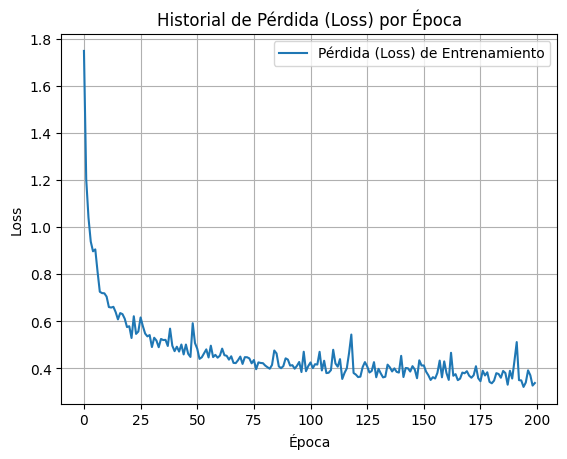


--- FASE 5: Probando modelo en cuda ---
Evaluando modelo contra el conjunto de prueba...


Evaluando: 100%|██████████| 230/230 [00:27<00:00,  8.41batch/s]



          RESULTADOS DE LA EVALUACIÓN (BIOMAS)
Accuracy (Exactitud): 0.7881 (78.81%)
Precision (Precisión - Macro): 0.7548 (75.48%)
Recall (Sensibilidad - Macro): 0.7625 (76.25%)

--- Reporte de Clasificación (Precisión, Recall, F1) ---
                        precision    recall  f1-score   support

              Badlands       0.91      0.98      0.95        64
          Bosque Mixto       0.35      0.19      0.24       459
       Bosque de Abeto       0.89      0.81      0.85       355
       Bosque de Roble       0.66      0.83      0.73       930
Bosque de Roble Oscuro       0.82      0.60      0.70       302
              Desierto       0.97      0.96      0.96       682
                Jungla       0.80      0.94      0.87       139
        Montaña Nevada       0.34      0.55      0.42       173
              Montañas       0.77      0.79      0.78       869
               Pantano       0.90      0.91      0.90       215
             Planicies       0.97      0.88      0.92    

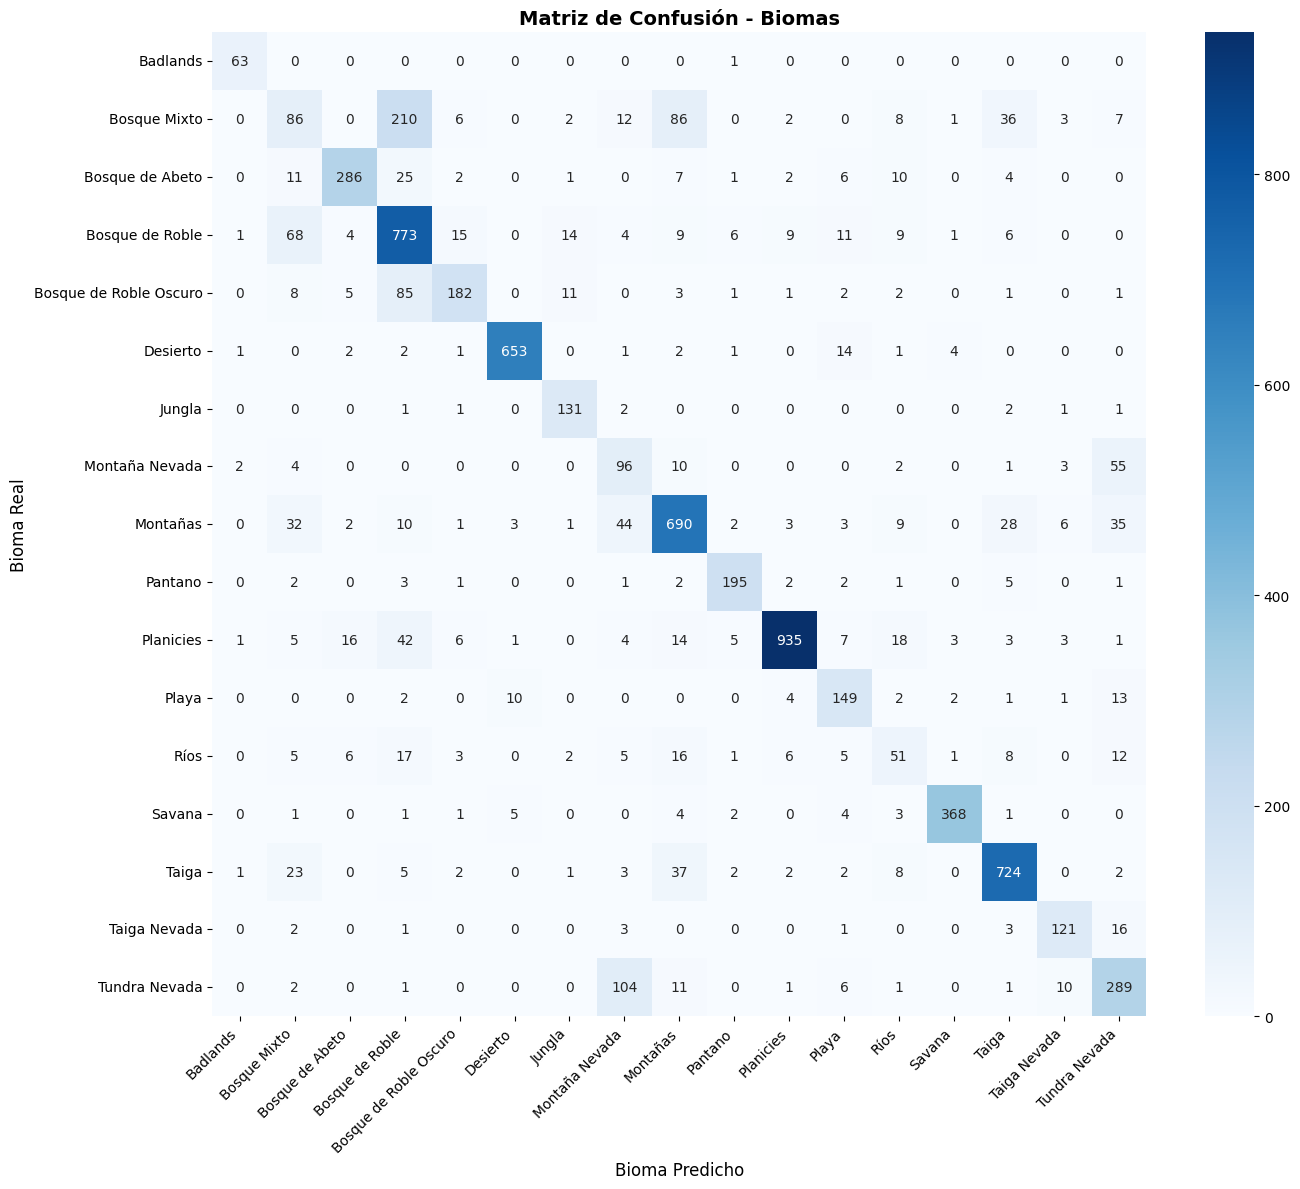

Gráfico de Matriz de Confusión generado.

--- FASE 6: Guardando modelo ---
Modelo guardado en /kaggle/working/auto_model_estandar_20251107_053818.pth

--- FLUJO AUTOMÁTICO COMPLETADO ---


In [9]:
if __name__ == "__main__":
    np.random.seed(SEMILLA_ALEATORIA)
    torch.manual_seed(SEMILLA_ALEATORIA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEMILLA_ALEATORIA)

    tipo_ejecucion_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown')

    if tipo_ejecucion_kaggle == 'Interactive':
        print("--- MODO INTERACTIVO (DRAFT) ---")
        print("Iniciando menú principal. Podrá usar 'input()'.\n")
        menu_principal()
    
    else:
        if tipo_ejecucion_kaggle == 'Batch':
            print("--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---")
        else:
            print(f"--- MODO NO INTERACTIVO (Fallback, KAGGLE_KERNEL_RUN_TYPE={tipo_ejecucion_kaggle}) ---")
        
        print("Iniciando flujo automático (sin inputs).\n")
        
        modelo_automatico = None
        params_arquitectura_auto = None
        historial_perdida_auto = []
        dispositivo_auto = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f" (Usando dispositivo: {dispositivo_auto})")

        try:
            print("\n--- FASE 1: Agrupando y verificando el dataset ---")
            if not preparar_y_agrupar_biomas():
                print("Error crítico en la agrupación del dataset. Abortando.")
                sys.exit(1)

            print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
            datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
            if datos_entrenamiento is None:
                print("No se pudieron cargar los datos. Abortando.")
                sys.exit(1)

            print("\n--- FASE 3: Creación de Modelo (CNN) ---")
            tipo_arquitectura_auto = "estandar"
            print(f"Arquitectura seleccionada: {tipo_arquitectura_auto}")
            
            params_arquitectura_auto = {
                'num_classes': numero_de_clases,
                'architecture_type': tipo_arquitectura_auto
            }
            params_creacion_auto = {
                'numero_de_clases': params_arquitectura_auto['num_classes'],
                'tipo_arquitectura': params_arquitectura_auto['architecture_type']
            }
            
            modelo_automatico = ClasificadorBiomasCNN(**params_creacion_auto).to(dispositivo_auto)
            print("\n--- Nueva Red CNN Creada ---")

            epocas_auto = 200
            lr_auto = 0.002
            porcentaje_auto = 1.0
            print(f"\n--- FASE 4: Iniciando Entrenamiento ---")
            print(f"Épocas: {epocas_auto}, LR: {lr_auto}, Dataset: {porcentaje_auto*100:.0f}%")
            
            total_muestras = len(pesos_muestras_tensor)
            muestras_a_usar = int(total_muestras * porcentaje_auto)
            muestreador_auto = torch.utils.data.WeightedRandomSampler(
                weights=pesos_muestras_tensor,
                num_samples=muestras_a_usar,
                replacement=True
            )
            cargador_entrenamiento_auto = DataLoader(datos_entrenamiento,
                                                    batch_size=TAMANO_LOTE,
                                                    sampler=muestreador_auto,
                                                    num_workers=2,
                                                    pin_memory=True)
            
            nueva_perdida_auto = entrenar_modelo(modelo_automatico, cargador_entrenamiento_auto, epocas_auto, lr_auto, dispositivo_auto)
            historial_perdida_auto.extend(nueva_perdida_auto)
            
            print("Generando gráfico de pérdida...")
            graficar_historial_perdida(historial_perdida_auto)

            print(f"\n--- FASE 5: Probando modelo en {dispositivo_auto} ---")
            evaluar_modelo(modelo_automatico, cargador_validacion, dispositivo_auto, nombres_clases)

            print("\n--- FASE 6: Guardando modelo ---")
            marca_temporal = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            nombre_archivo_modelo = f"auto_model_estandar_{marca_temporal}.pth"
            guardar_red_neuronal(modelo_automatico, params_arquitectura_auto, nombre_archivo_modelo)
            
            print("\n--- FLUJO AUTOMÁTICO COMPLETADO ---")

        except Exception as e:
            print(f"Ocurrió un error en el flujo automático: {e}")
            import traceback
            traceback.print_exc()
            sys.exit(1)